In [1]:
# Robust metadata path discovery (auto-detect CSV)
import pathlib, os, pandas as pd
CANDIDATES = [
    'notebooks/data/metadata/kaggle_pneumonia_metadata_clean.csv',
    'data/metadata/kaggle_pneumonia_metadata_clean.csv',
    'kaggle_pneumonia_metadata_clean.csv'
]
METADATA_PATH = None
for c in CANDIDATES:
    p = pathlib.Path(c)
    if p.is_file():
        METADATA_PATH = str(p)
        break
if METADATA_PATH is None:
    raise FileNotFoundError('Could not locate metadata CSV. Tried: ' + ', '.join(CANDIDATES))
print('Using metadata CSV:', METADATA_PATH)
# Lazy load helper (avoid double loading if notebook later loads df itself)
def load_metadata():
    return pd.read_csv(METADATA_PATH)


Using metadata CSV: data/metadata/kaggle_pneumonia_metadata_clean.csv


# Chest X-Ray Transform Visualization Demo
Visual inspection of preprocessing and augmentation (torchvision + albumentations).

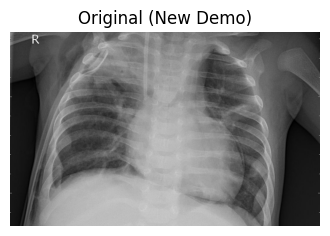

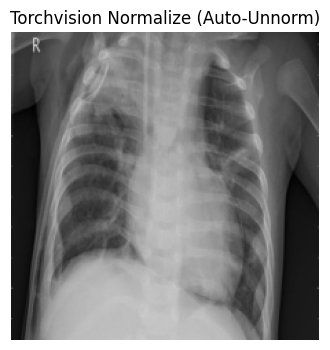

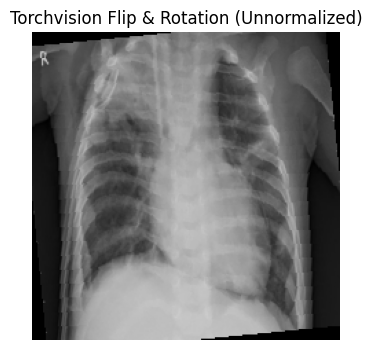

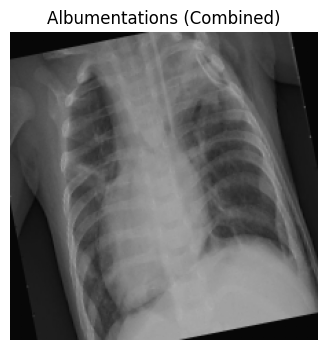

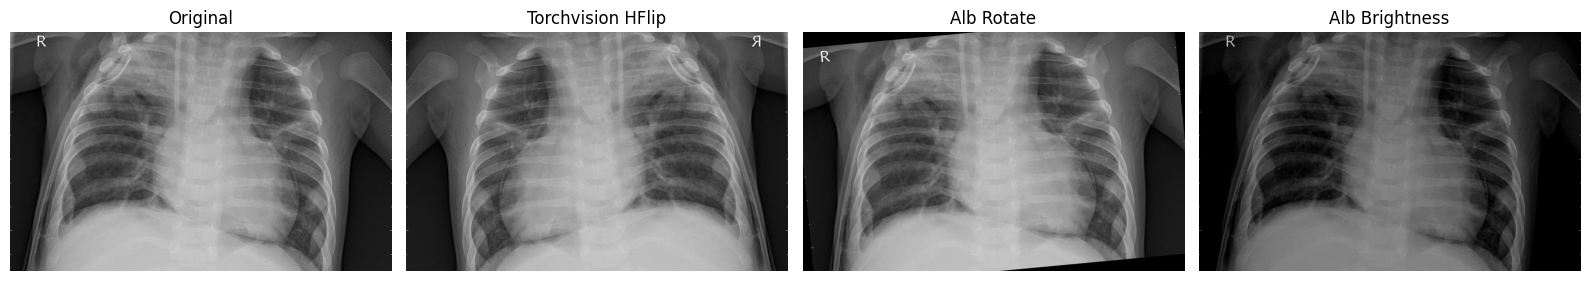

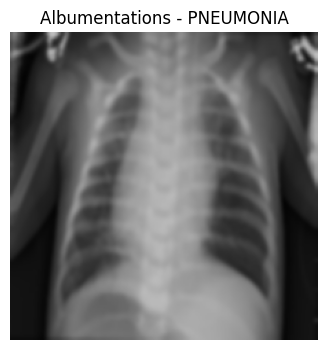

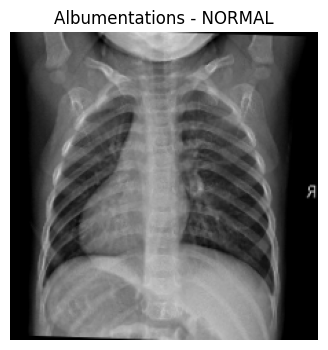

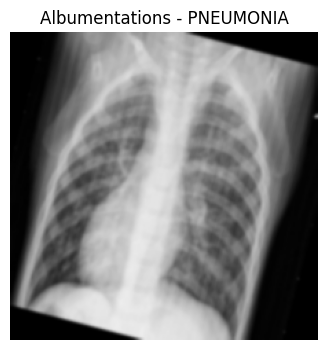

Automatic unnormalization demo complete (new cell).


In [2]:
# Cell (New): Automatic Unnormalization Transform Visualization Demo
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import albumentations as A
import numpy as np
import pandas as pd
from pathlib import Path

# Helper for display

def unnormalize_tensor(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

def show_torchvision_transform(img, transform, title, normalize=False):
    aug = transform(img)
    if normalize:
        aug = unnormalize_tensor(aug)
    arr = aug.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(arr)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_albumentations_transform(img, alb_transform, title):
    arr = np.array(img)
    aug = alb_transform(image=arr)['image']
    aug_np = aug if isinstance(aug, np.ndarray) else aug.permute(1,2,0).cpu().numpy()
    aug_np = np.clip(aug_np.astype('float32') / (255.0 if aug_np.max()>1.5 else 1.0), 0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(aug_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Locate metadata
meta_candidates = [
    Path('notebooks/data/metadata/kaggle_pneumonia_metadata_clean.csv'),
    Path('data/metadata/kaggle_pneumonia_metadata_clean.csv'),
    Path.cwd() / 'notebooks' / 'data' / 'metadata' / 'kaggle_pneumonia_metadata_clean.csv',
]
meta_path = None
for c in meta_candidates:
    if c.exists(): meta_path = c; break
if meta_path is None:
    raise FileNotFoundError('Could not locate metadata CSV for demo.')

df_demo = pd.read_csv(meta_path)
if 'corrupted' in df_demo.columns: df_demo = df_demo[~df_demo['corrupted']]
if 'class' not in df_demo.columns and 'label' in df_demo.columns:
    df_demo = df_demo.rename(columns={'label':'class'})
img_path = df_demo.sample(1, random_state=314)['path'].iloc[0]
base_img = Image.open(img_path).convert('RGB')
plt.figure(figsize=(4,4)); plt.imshow(base_img); plt.title('Original (New Demo)'); plt.axis('off'); plt.show()

# Torchvision normalized (auto unnormalize)
t_transform_norm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
show_torchvision_transform(base_img, t_transform_norm, 'Torchvision Normalize (Auto-Unnorm)', normalize=True)

# Torchvision augmentation (no normalization)
t_transform_aug = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])
show_torchvision_transform(base_img, t_transform_aug, 'Torchvision Flip & Rotation (Unnormalized)')

# Albumentations (no tensor conversion for visualization)
alb_transform_adv = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.7),
    A.Rotate(limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
])
show_albumentations_transform(base_img, alb_transform_adv, 'Albumentations (Combined)')

# Panel comparison
fig, axs = plt.subplots(1,4, figsize=(16,4))
panel_imgs = [
    ('Original', np.array(base_img)),
    ('Torchvision HFlip', np.array(TF.hflip(base_img))),
    ('Alb Rotate', A.Rotate(limit=30, p=1)(image=np.array(base_img))['image']),
    ('Alb Brightness', A.RandomBrightnessContrast(p=1)(image=np.array(base_img))['image'])
]
for ax,(title,arr) in zip(axs,panel_imgs):
    arr_disp = arr.astype('float32') / (255.0 if arr.max()>1.5 else 1.0)
    ax.imshow(arr_disp); ax.set_title(title); ax.axis('off')
plt.tight_layout(); plt.show()

# Batch demo
for _, row in df_demo.sample(min(3, len(df_demo)), random_state=123).iterrows():
    p = row['path']; lb = row['class']
    im = Image.open(p).convert('RGB')
    show_albumentations_transform(im, alb_transform_adv, f'Albumentations - {lb}')

print('Automatic unnormalization demo complete (new cell).')